In [30]:
import requests
from scipy.io import loadmat
from scipy.sparse.linalg import svds
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import scipy
from scipy.sparse import diags
from numpy import linalg as LA
from scipy.sparse.linalg import svds, eigs, bicg, LinearOperator
np.random.seed(2025)

# I - X-ray tomography

Question 1: Download the data.

In [3]:
H, x = loadmat("data/H.mat")['H'], loadmat("data/x.mat")['x']
x = x.squeeze()

M, N = H.shape
print(f"M = {M}, N = {N}")
print("x has good shape" if N == x.size else  "x has bad shape")

M = 16200, N = 8100
x has good shape


Question 2: Construct $y$, according to model $(1)$, using $\sigma  = 1$.

In [4]:
noise = np.random.normal(loc = 0, scale = 1, size = M)  # Build some noise
y = H.dot(x) + noise  # Build the y vector

Question 3: Display a 2D version of x and a 2D version of y, also known as sinogram.

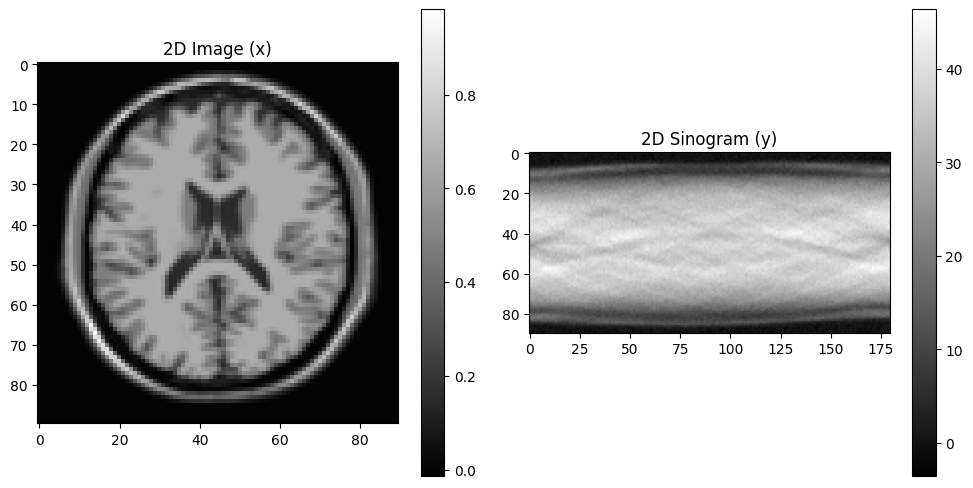

In [5]:
# Reshape to 2D
x_2d = x.reshape((90, 90), order='F')  # Reshape for 2D image
y_2d = y.reshape((90, 180), order='F')  # Reshape for 2D sinogram

# Display the 2D image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(x_2d, cmap='gray')
plt.title("2D Image (x)")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_2d, cmap='gray')
plt.title("2D Sinogram (y)")
plt.colorbar()

plt.tight_layout()
plt.show()

# II - Optimization problem

### Reconstruction Problem: Penalized Least-Squares Criterion

An efficient strategy to address the reconstruction problem is to define **x** as a minimizer of an appropriate cost function **f**. Specifically, we consider the following penalized least-squares criterion:

$$
\forall x \in \mathbb{R}^N, \quad f(x) = \frac{1}{2} \|Hx - y\|^2 + \lambda r(x), \tag{2}
$$

where:
- **$H$** is the system matrix.
- **$y$** is the observed data.
- **$r(x)$** is a regularization function incorporating a priori assumptions to improve robustness against noise.

---

#### Regularization Function

To promote images with smooth regions separated by sharp edges, we define the regularization function as:

$$
\forall x \in \mathbb{R}^N, \quad r(x) = \sum_{n=1}^{2N} \psi([Gx]_n), \tag{3}
$$

Here:
- **$ G \in \mathbb{R}^{2N \times N} $** is a sparse matrix such that $ Gx \in \mathbb{R}^{2N} $ concatenates the horizontal and vertical gradients of the image.
- **$ \psi $** is a potential function, defined as: $\psi(t) = \sqrt{t^2 + \delta}, \quad \delta > 0.$

The parameter **$ \delta $** ensures the differentiability of the regularization function.

---

### Parameter Selection

In the following computations, we will set the parameters as: $\lambda = 0.13, \quad \delta = 0.02$.


In [6]:
lambda_ = 0.13
delta_ = 0.02

Question 1: Download the gradient operator G available in the website.

In [7]:
dataG = loadmat("data/G.mat")
G = dataG['G']
assert G.shape == (2 * N, N)

Question 2: Give the expression of the gradient $ \nabla f$ at some point $x \in \mathbb{R}^N $. Create a function which gives as an output the gradient of $f$ at some input vector x.

First, $ \forall u \in \mathbb{R}, \text{ } \psi ^{'} (u) = \displaystyle \frac{u}{\delta ^2 \sqrt{1 + \frac{u ^2}{\delta ^2}}}$.

Then, we have : $\forall x \in \mathbb{R}^N, \text{ } \nabla f (x) = H^{\text{T}} (Hx - y) + \lambda \displaystyle \sum _{n=1} ^{2N} \psi ^{'} ( \left[ Gx \right]^{(n)} ) G^{(n)} = H^{\text{T}} (Hx - y) + \lambda G^{T} ( \psi ^{'} (\left[ Gx\right]_i) )_{i \in \left[1, 2n \right]}$.

In [10]:
def gradient_f(x):
    """ Define the gradient of the f function """
    psi_grad = G.dot(x) / (delta_ ** 2 * np.sqrt(1 + G.dot(x) ** 2 / delta_ ** 2))
    return H.T.dot(H.dot(x) - y) + lambda_ * G.T.dot(psi_grad)

In [12]:
def f(x):
    """ Define the f function """
    first = 0.5 * np.linalg.norm(H.dot(x) - y) ** 2 
    G_x = G.dot(x)
    second = lambda_ * np.sum([delta_ * np.sqrt(1 + (G_x[n] / delta_) ** 2) for n in range(G_x.size)])
    return first + second

Question 3: Show that a Lipschitz constant of $ \nabla f$ is $L = || H ||^2 + \frac{ \lambda }{\delta ^2} ||G||^2$.

We would like to show the following properties of the gradient of the f function:

$$ \forall x,y \in \mathbb{R}^N, \text{ } || \nabla f (x) - \nabla f (y)|| \leq L || x - y || $$

By the mean value theorem, we have:

$$
\|\nabla f(x) - \nabla f(y)\| \leq \|\nabla^2 f\| \|y - x\|
$$

Therefore, it is sufficient to prove that:

$$
\|\nabla^2 f\| \leq \|H\|^2 + \frac{\lambda}{\delta^2} \|G\|^2
$$

---

### Calculating Derivatives

We calculate the first and second derivatives of $f$ as follows:

$$
\begin{align}
\nabla f &= H^{ \text{T}}(Hx - y) + \lambda \sum_{n=1} ^{2N} \Psi ^{'} \left( [Gx]^{(n)} \right) G^{(n)} \\ 
\nabla ^2 f &= H^{ \text{T}} H + \lambda \sum_{n=1}^{2N} \Psi ^{''} \left( [Gx]^{(n)} \right) [G^{(n)} G^{(n) \text{T}}]  \\
\end{align}
$$

---

### Properties of the Potential Function

The derivatives of $ \Psi $ are given by:

$$
\begin{align}
\Psi^{\prime}(u) &= \frac{u}{\delta^2 \sqrt{1 + \frac{u^2}{\delta^2}}} \\\\
\Psi^{\prime\prime}(u) &= \frac{\delta^2 \sqrt{1 + \frac{u^2}{\delta^2}} - u \left[\frac{\delta^2 u}{\delta^2 \sqrt{1 + \frac{u^2}{\delta^2}}}\right]}{\delta^4 \left(1 + \frac{u^2}{\delta^2}\right)} \\\\
&= \frac{\delta^2 \left(1 + \frac{u^2}{\delta^2}\right) - u^2}{\delta^4 \left(1 + \frac{u^2}{\delta^2}\right)}
\end{align}
$$

The maximum of $ \Psi^{\prime\prime}$ is reached when $u = 0$. Thus:

$$
\Psi^{\prime\prime}(0) = \frac{1}{\delta^2}
$$

---

### Substituting into the Expression for $ \nabla^2 f $

We obtain:

$$
\nabla^2 f = H^{\top}H + \frac{\lambda}{\delta^2} G^{\top}G
$$

---

### Bounding the Norm

Calculating the norm on both sides, we have:

$$
\begin{align}
\|\nabla^2 f\|_2 &= \|H^{\top}H\|_2 + \frac{\lambda}{\delta^2} \|G^{\top}G\|_2 \\\\
&\leq \|H\|_2 \|H^{\top}\|_2 + \frac{\lambda}{\delta^2} \|G\|_2 \|G\|_2 \\\\
&= \|H\|_2^2 + \frac{\lambda}{\delta^2} \|G\|_2^2
\end{align}
$$

In [14]:
norm_H = np.max(svds(H, return_singular_vectors=False))
norm_G = np.max(svds(G, return_singular_vectors=False))

L = (norm_H ** 2) + lambda_ / (delta_ ** 2) * (norm_G ** 2)
print(f"Lipschitz constant: {L}")

Lipschitz constant: 18092.77327686477


# Optimization algorithms

## Gradient descent algorithm

Question 1: Create $x_0 \in \mathbb{R} ^N$ a vector with all entries equal to 0. This will be our initiali- zation for all tested algorithms.

In [15]:
x_0 = np.zeros(N)

Question 2: Implement a gradient descent algorithm to minimize f.

**Gradient Descent Algorithm**

Let $ \gamma \in ]0, +\infty[ $ and $ x_0 \in H $. The iterative scheme is defined as follows:

$$
x_{n+1} = x_n - \gamma \nabla f(x_n), \quad \text{for } n = 0, 1, \dots
$$

The sequence $(x_n)_{n \in \mathbb{N}}$ generated by this explicit scheme converges to a minimizer of $ f $, provided that such a minimizer exists and $ \gamma \in ]0, 2/\beta[ $.


In [16]:
def gradient_descent(x_0, step_size, max_iter = 10 ** 2):
    """ Perform the gradient descent for the function f"""
    assert 0 < step_size < 2 / L, "step_size must be in (0, 2 / L) to ensure convergence"
    x = x_0
    list_x = [x]
    for _ in tqdm(range(max_iter)):
        x = x - step_size * gradient_f(x)
        list_x.append(x)
    plt.figure(figsize = (10, 5))
    plt.plot(list(range(max_iter + 1)) ,[f(x) for x in list_x])
    plt.xlabel("Iteration")
    plt.ylabel("f(x)")
    plt.legend()
    plt.show()
    return x

100%|██████████| 100/100 [00:00<00:00, 201.43it/s]
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_3223/3403136663.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


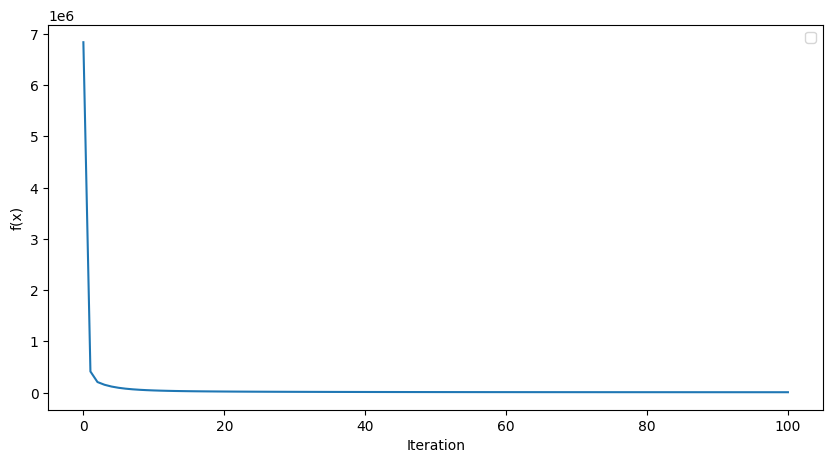

In [17]:
x_star = gradient_descent(x_0, step_size = 1 / L)

Text(0.5, 1.0, 'Reconstruction image')

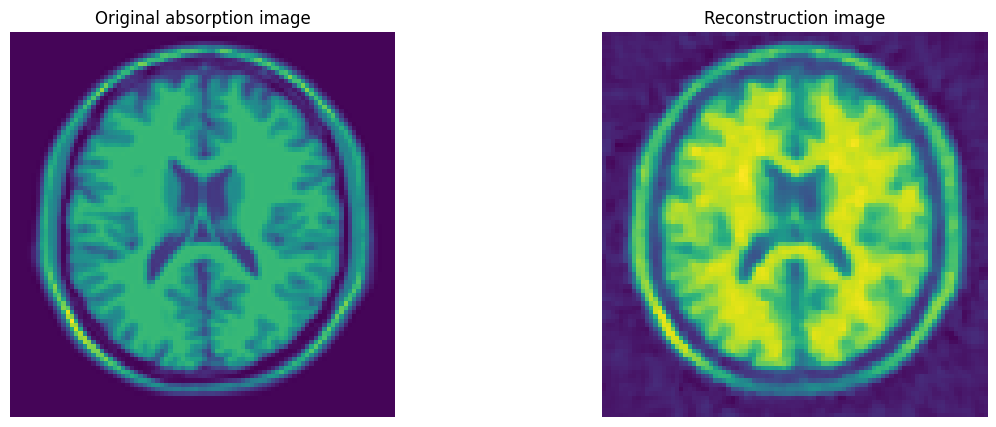

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(x.reshape((90, 90), order="F"))
axes[0].set_axis_off()
axes[0].set_title("Original absorption image");
axes[1].set_axis_off()
axes[1].imshow(x_star.reshape((90, 90), order="F"))
axes[1].set_title("Reconstruction image")

## MM quadratic algorithm

The MM principle consists of solving a minimization problem by alternating between two steps:
- 1. Majorize the criterion at current iterate with a majorant function 
- 2. Minimize the majorant function to define the next iterate.

Question 1: Construct, for all $x \in \mathbb{R}^N$, a quadratic majorant function of $f$ at $x$. Create a function which gives, as an output, the curvature $A(x)$ of the majorant function at an input vector $x$.

Let us recall that f is defined by:
$$
\forall x \in \mathbb{R}^N, \quad f(x) = \frac{1}{2} \|Hx - y\|^2 + \lambda r(x)
$$

--- 

First, we've shown that $f$ is L-Lipschitz differentiable function. 
From the class, we've the following property: 

>Property: 

Let $f : H \to ]-\infty, +\infty]$ be a $\beta$-Lipschitz differentiable function on $\mathcal{H}$. 

Then, for every $y \in H$ and for every $\mu \in [\beta, +\infty[$, a majorant function for $f$ at $y \in \mathcal{H}$ is:

$$
\forall x \in H, \quad h(x, y) = f(y) + \langle \nabla f(y) \mid x - y \rangle + \frac{\mu}{2} \|x - y\|^2.
$$

--- 
In our case, we've the following: 

$$
\forall x \in \mathbb{R}^N, \quad h(x, z) = f(z) + \langle \nabla f(z) \mid x - z \rangle + \frac{\mu}{2} \|x - z\|^2 = \frac{1}{2} \|Hz - y\|^2 + \lambda r(z) + \langle \nabla f(z) \mid x - z \rangle + \frac{\mu}{2} \|x - z\|^2.
$$

Where $ \nabla f (z) = H^{ \text{T}}(Hz - y) + \lambda \sum_{n=1} ^{2N} \Psi ^{'} \left( [Gz]^{(n)} \right) G^{(n)} $. 
$ \nabla f $ is already implemented.

The curvature is determined by the coefficient of the quadratic term in $x$, so we have:

$$ A(x) = H^{T} H + \lambda G^{T} \text{D} (Gx) G $$

where, $D(Gx)= \text{diag} ( ( \frac{ \Psi ^{'} (|Gx|)}{|Gx|_i} ) _i )$.

In [19]:
def A(x):
    """ Define the A operator """
    # Define a diagonal sparse matrix 
    d = 1 / (delta_ ** 2 * np.sqrt(1 + G.dot(x) ** 2 / delta_ ** 2)) 
    
    D_G = diags(d).tocsc()
    # Combine intermediate results using sparse operations
    return lambda v: H.T.dot(H.dot(v)) + lambda_ * G.T.dot(D_G.dot(G.dot(v)))

Question 2: Deduce a MM quadratic algorithm to minimize f. Implement it.

>Majorization-Minimization algorithm

Problem : Minimization of function $f : H \to \left]-\infty, +\infty \right]$.

$$
x_{n+1} = x_n - \theta _n A(x_n) ^{-1} \nabla f(x_n)
$$

where $\theta _n \in \left] 0, 2\right[ $.

In [25]:
def MM(x_0, tol = 1e-3):
    """ Define the MM algorithm """
    x = x_0 
    x_ = [x]
    while np.linalg.norm(gradient_f(x)) > np.sqrt(N) * tol:
        A_x = LinearOperator(shape=(N, N), matvec = A(x), rmatvec = A(x))
        x = x - bicg(A = A_x, b = gradient_f(x))[0]
        x_.append(x)
    plt.figure(figsize = (10, 5))
    plt.plot(list(range(len(x_))) ,[f(x) for x in x_])
    plt.xlabel("Iteration")
    plt.ylabel("f(x)")
    plt.legend()
    return x 

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_3223/2956243788.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


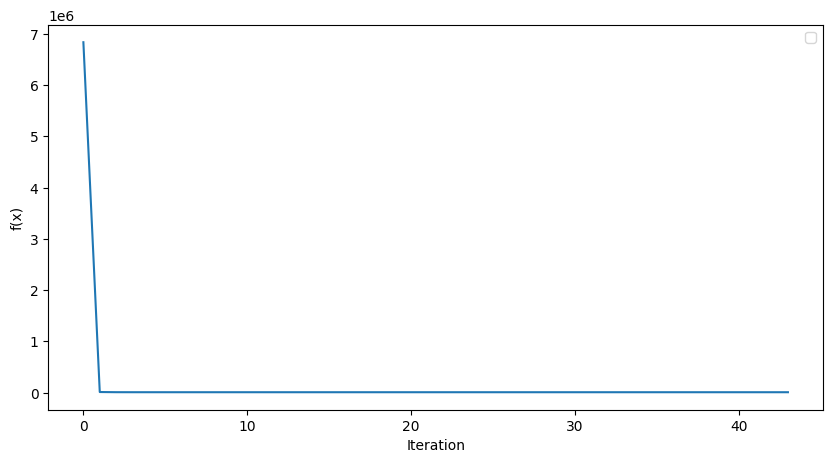

In [26]:
x_star_MM = MM(x_0)

Text(0.5, 1.0, 'Reconstruction image')

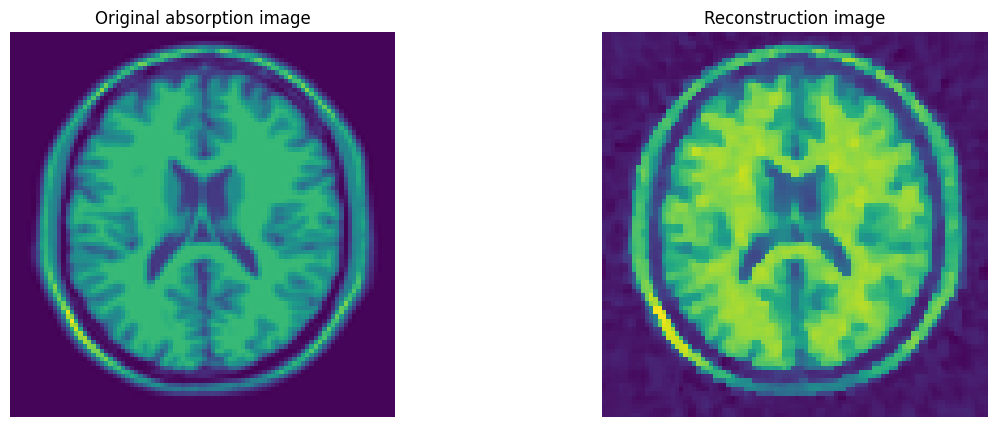

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(x.reshape((90, 90), order="F"))
axes[0].set_axis_off()
axes[0].set_title("Original absorption image");
axes[1].set_axis_off()
axes[1].imshow(x_star_MM.reshape((90, 90), order="F"))
axes[1].set_title("Reconstruction image")

## 3MG algorithm

The MM quadratic algorithm can be accelerated by using a subspace strategy. Here, we will focus on the so-called **3MG (MM Memory Gradient)** approach, which consists in defining the iterate $x_{k+1}$ as the minimizer of the quadratic majorant function at $x_k$ within a subspace spanned by the following directions:

$$
(\forall k \in \mathbb{N}) \quad D_k = [-\nabla f(x_k) \,|\, x_k - x_{k-1}], \tag{5}
$$
(with the convention $D_0 = -\nabla f(x_0)$).

Thus, an iterate of 3MG reads:
$$
(\forall k \in \mathbb{N}) \quad x_{k+1} = x_k + D_k u_k, \tag{6}
$$
where
$$
(\forall k \in \mathbb{N}) \quad u_k = -(D_k^\top A(x_k) D_k)^\dagger (D_k^\top \nabla f(x_k)), \tag{7}
$$
and $A(x_k) \in \mathbb{R}^{N \times N}$ is the curvature of the majorant matrix at $x_k$, and $\dagger$ denotes the pseudo-inverse operation.


Question 1: Implement the 3MG algorithm.

In [31]:
def MM_Memory_Gradient(x_0, tol = 1e-3):
    """ Define the MM algorithm with memory gradient """
    x = x_0 
    x_ = [x]
    iter = 0
    while np.linalg.norm(gradient_f(x)) > np.sqrt(N) * tol:
        if iter == 0:
            D = - gradient_f(x).reshape(-1, 1)
        else:
            D = np.hstack([- gradient_f(x).reshape(-1, 1), (x - x_[-1]).reshape(-1, 1)])
        # Compute u_k 
        d = 1 / (delta_ ** 2 * np.sqrt(1 + G.dot(x) ** 2 / delta_ ** 2))
        D_G = diags(d).tocsc()
        pseudo_inverse = -scipy.linalg.pinv(H.dot(D).T.dot(H.dot(D)) + lambda_ + G.dot(D).T.dot(D_G.dot(G.dot(D)))).dot((D.T).dot(gradient_f(x).reshape(-1, 1)))
        x = x + D.dot(pseudo_inverse).squeeze()
        x_.append(x)
    plt.figure(figsize = (10, 5))
    plt.plot(list(range(len(x_))) ,[f(x) for x in x_])
    plt.xlabel("Iteration")
    plt.ylabel("f(x)")
    plt.legend()
    return x 


/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_3223/2956243788.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


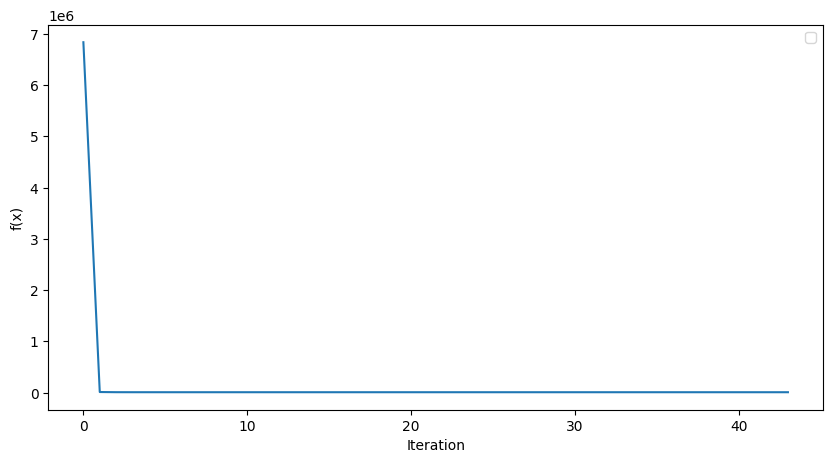

In [32]:
x_star_MM_Memory_Gradient = MM(x_0)

Text(0.5, 1.0, 'Reconstruction image')

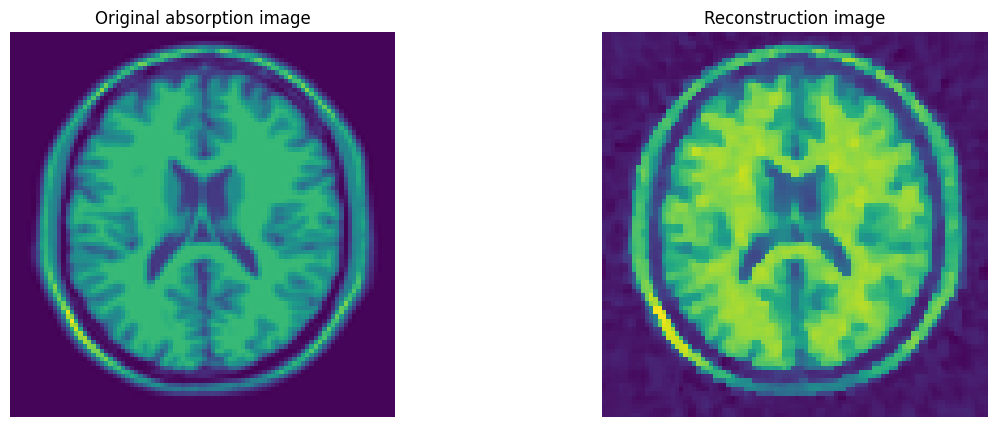

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(x.reshape((90, 90), order="F"))
axes[0].set_axis_off()
axes[0].set_title("Original absorption image");
axes[1].set_axis_off()
axes[1].imshow(x_star_MM_Memory_Gradient.reshape((90, 90), order="F"))
axes[1].set_title("Reconstruction image")

## Block-coordinate MM quadratic algorithm

Another acceleration strategy consists in applying a block alternation technique. The vector $x$ is divided into $J \geq 1$ blocks, with size $1 \leq N_j \leq N$. At each iteration $k \in \mathbb{N}$, a block index $j \subset \{1, \ldots, J\}$ is chosen, and the corresponding components of $x$, denoted $x^{(j)}$, are updated according to an MM quadratic rule. 

Here, we will assume that the blocks are selected in a cyclic manner, that is:

$$
(\forall k \in \mathbb{N}) \quad j = \text{mod}(k-1, J) + 1. \tag{8}
$$

For a given block index $j$, the corresponding pixel indexes are updated in the image:

$$
n \in J_j = \{N_j (j-1) + 1, \ldots, j N_j\}.
$$

Question 1: Create a function that outputs the matrix $A_j(x) \in \mathbb{R}^{N_j \times N_j}$, 
containing only the rows and columns of $A(x)$ indexed by $J_j$: $A_j(x) = A(x)_{J_j, J_j}$, where $A(x)_{J_j, J_j}$ denotes the submatrix of $A(x)$ formed by selecting the rows and columns corresponding to the indices in $J_j$.


Question 2: Deduce an implementation of a block coordinate MM quadratic algorithm for minimizing f. 

## Parallel MM quadratic algorithm